In [13]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL
import opendatasets as od
import tensorflow as tf
import warnings 
import argparse
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Importing the required libraries for modelling 
from keras import Input, Model
from keras.applications import MobileNet
from keras.layers import Flatten, Dense,Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score

In [32]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np
import cv2
import json

In [4]:
od.download("https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aparpokhrel
Your Kaggle Key: ··········


100%|██████████| 2.70G/2.70G [01:10<00:00, 41.1MB/s]


In [5]:
data_dir = "/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

In [17]:
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"

class_diseases = os.listdir(train_dir)
print(class_diseases)
print("Total # of disease classes: {}".format(len(class_diseases)))

['Potato___Late_blight', 'Potato___Early_blight', 'Tomato___Target_Spot', 'Tomato___Bacterial_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Apple___Black_rot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___healthy', 'Grape___Esca_(Black_Measles)', 'Peach___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Apple___Apple_scab', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Late_blight', 'Squash___Powdery_mildew', 'Apple___Cedar_apple_rust', 'Soybean___healthy', 'Pepper,_bell___Bacterial_spot', 'Tomato___Septoria_leaf_spot', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Peach___Bacterial_spot', 'Grape___healthy', 'Tomato___Early_blight', 'Potato___healthy', 'Raspberry___healthy', 'Corn_(maize)___healthy', 'Tomato___Tomato_mosaic_virus', 'Blueberry___healthy', 'Apple___healthy', 'Tomato___Leaf_Mold', 'Corn_(maize)___Common_rust_', 'Strawberry___healthy', 'Grape___Black_rot', 'Strawberry___Leaf_scorch', 'Pepper,

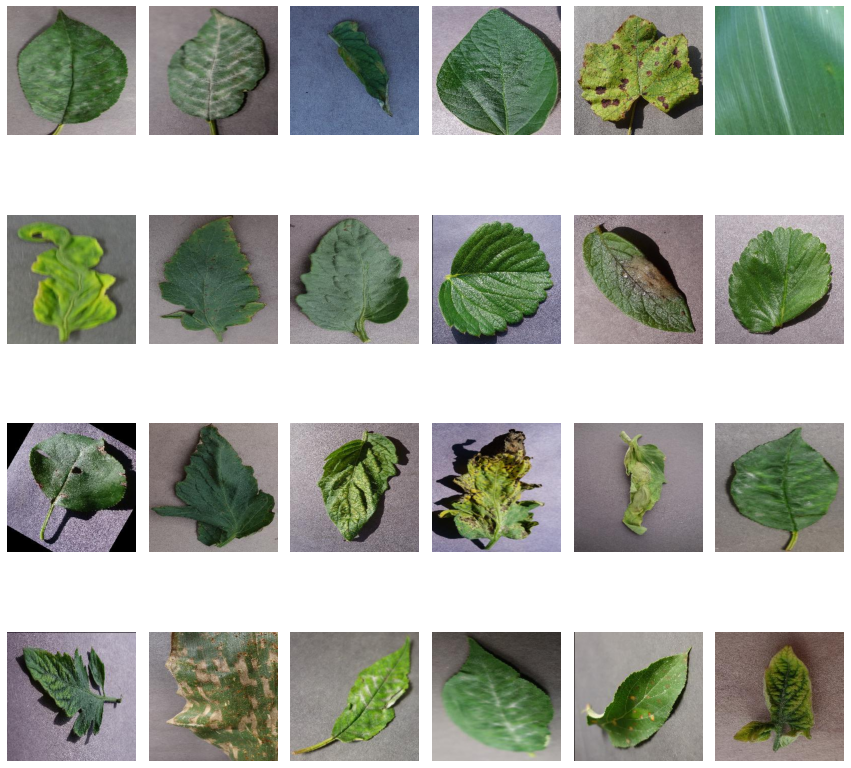

In [16]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(24):
    random_folder=np.random.randint(0,len(os.listdir(train_dir)))
    random_folder_path=os.path.join(train_dir,os.listdir(train_dir)[random_folder])
    random_image=np.random.randint(0,len(os.listdir(random_folder_path)))
    random_image_path=os.path.join(random_folder_path,os.listdir(random_folder_path)[random_image])
    image=cv2.imread(random_image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.subplot(4,6,i+1)
    plt.imshow(image)
    plt.axis("off")
plt.show()

In [20]:
numberof_images={}
for class_name in class_diseases:
    numberof_images[class_name]=len(os.listdir(train_dir+"/"+class_name))
images_each_class=pd.DataFrame(numberof_images.values(),index=numberof_images.keys(),columns=["Number of images"])
images_each_class

,Number of images
Potato___Late_blight,1939
Potato___Early_blight,1939
Tomato___Target_Spot,1827
Tomato___Bacterial_spot,1702
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,1642
Apple___Black_rot,1987
Tomato___Spider_mites Two-spotted_spider_mite,1741
Tomato___healthy,1926
Grape___Esca_(Black_Measles),1920
Peach___healthy,1728


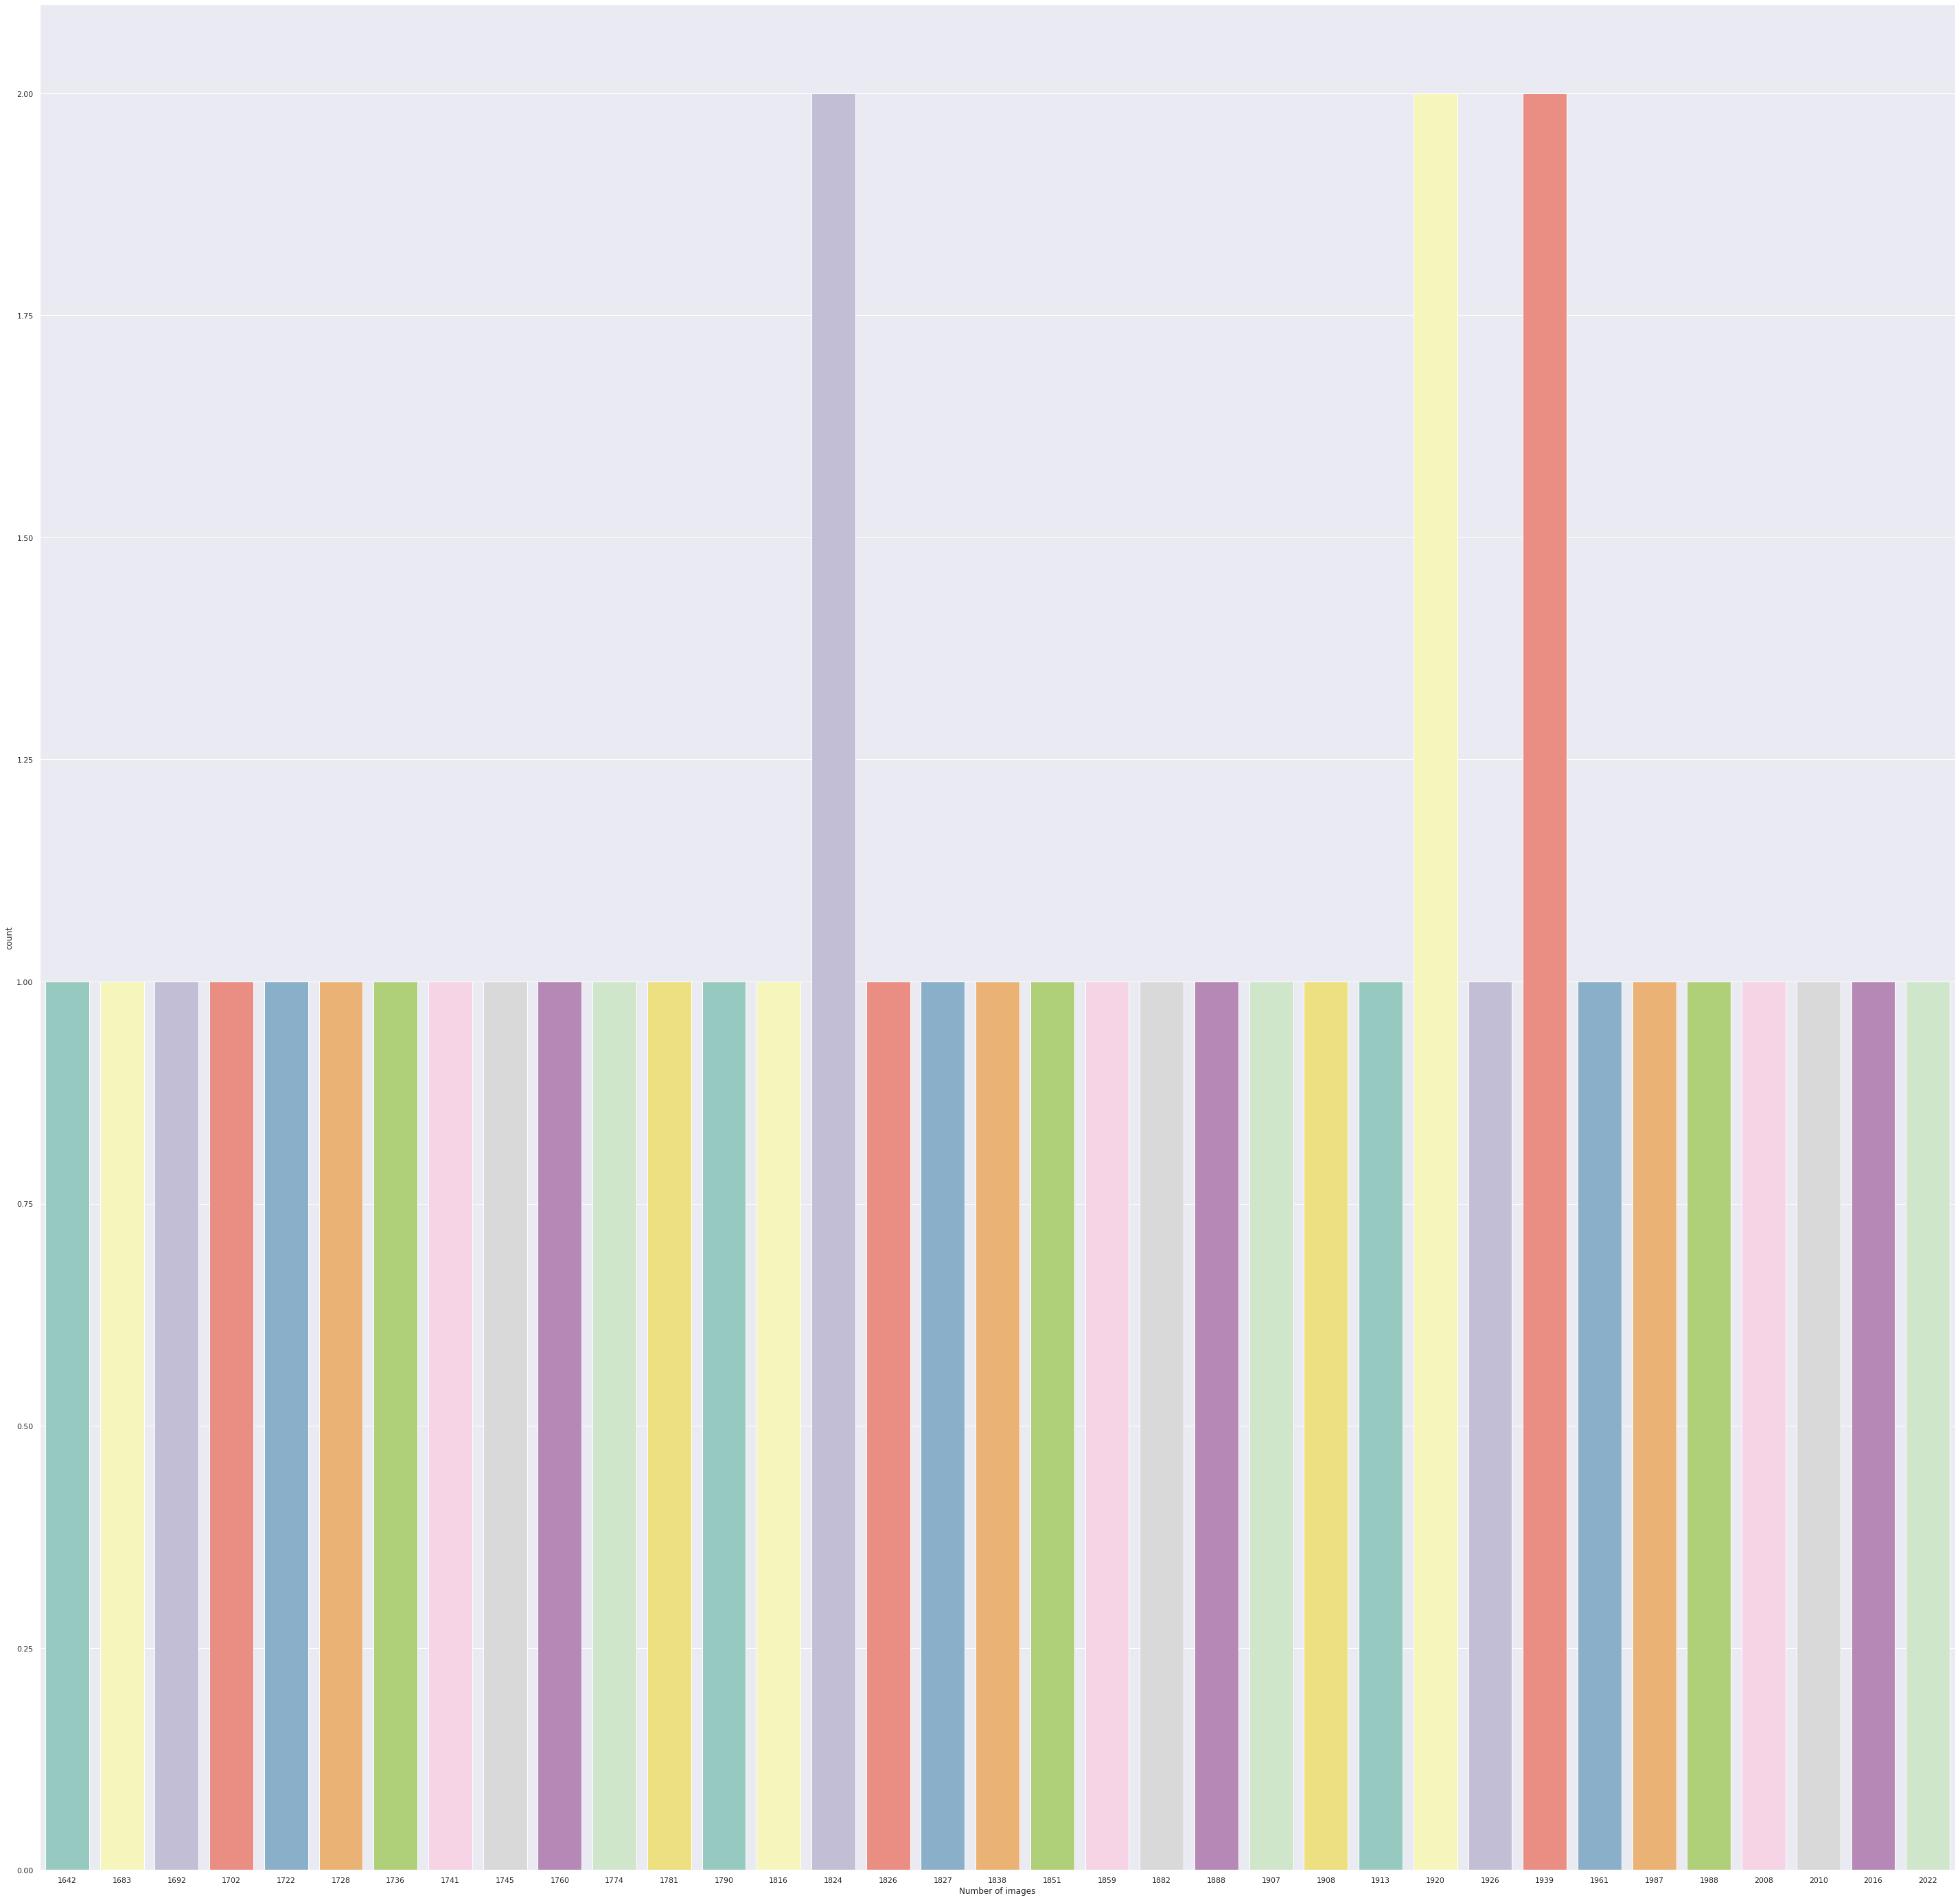

In [21]:
sns.set(rc={'figure.figsize':(50,50)})
ax = sns.countplot(x="Number of images", data=images_each_class,palette="Set3")

In [30]:
train_gen= ImageDataGenerator(rescale=1./255,
                              zoom_range=0.2,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              horizontal_flip=True,
                              validation_split=0.2)

valid_gen=ImageDataGenerator(rescale= 1./255)


In [31]:

BATCH_SIZE = 32

train_set = train_gen.flow_from_directory(os.path.join(data_dir, 
                                                      'train'),
                                                       target_size = (224,224),
                                                       batch_size = BATCH_SIZE,
                                                       class_mode = 'categorical' )

valid_set = valid_gen.flow_from_directory(os.path.join(data_dir, 
                                                       'valid'),
                                                        target_size = (224,224),
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = 'categorical')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [33]:
dict_classes = train_set.class_indices

with open('/content/data/class_indices.json','w') as f:
    json.dump(dict_classes, f)

In [34]:
mobilenet_model = MobileNet(
                            weights = "imagenet",
                            input_shape = (224, 224, 3),
                            include_top = False                    
)

17225924/17225924 [==============================] - 0s 0us/step


In [35]:
mobilenet_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [37]:
start_model = mobilenet_model.output
start_model = GlobalAveragePooling2D()(start_model)
start_model = Dropout(0.2)(start_model)

outputs = Dense(38, activation="softmax")(start_model)

final_model = Model(mobilenet_model.input, outputs, name='pretrained_mobilenet' )

#Freezing 
for layer in final_model.layers:
    layer.trainable = False

for layer in final_model.layers[:20]:
    layer.trainable=False
for layer in final_model.layers[20:]:
    layer.trainable=True

In [38]:
final_model.summary()

Model: "pretrained_mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                       

In [39]:
final_model.compile(optimizer= Adam(),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])


In [46]:
callbacks = [ModelCheckpoint('/content/model/best)model.h5', save_best_only=True, monitor='val_acc'),
              ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1)]


In [47]:
num_epochs = 30

history = final_model.fit(train_set,
                          validation_data = valid_set,
                          epochs = num_epochs,
                          steps_per_epoch = 128,
                          validation_steps = 100,
                          callbacks = callbacks)

Epoch 1/30
128/128 [==============================] - ETA: 0s - loss: 0.1241 - accuracy: 0.9624

128/128 [==============================] - 58s 451ms/step - loss: 0.1241 - accuracy: 0.9624 - val_loss: 0.2314 - val_accuracy: 0.9372 - lr: 0.0010
Epoch 2/30
128/128 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9597

128/128 [==============================] - 60s 471ms/step - loss: 0.1289 - accuracy: 0.9597 - val_loss: 0.7388 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 3/30
128/128 [==============================] - ETA: 0s - loss: 0.1529 - accuracy: 0.9514

128/128 [==============================] - 67s 525ms/step - loss: 0.1529 - accuracy: 0.9514 - val_loss: 0.3603 - val_accuracy: 0.9028 - lr: 0.0010
Epoch 4/30
128/128 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.9604

128/128 [==============================] - 57s 444ms/step - loss: 0.1336 - accuracy: 0.9604 - val_loss: 0.6371 - val_accuracy: 0.8634 - lr: 0.0010
Epoch 5/30
128/128 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9575

128/128 [==============================] - 57s 445ms/step - loss: 0.1369 - accuracy: 0.9575 - val_loss: 0.6940 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 6/30
128/128 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.9531

128/128 [==============================] - 56s 438ms/step - loss: 0.1475 - accuracy: 0.9531 - val_loss: 0.4641 - val_accuracy: 0.8775 - lr: 0.0010
Epoch 7/30
128/128 [==============================] - ETA: 0s - loss: 0.1235 - accuracy: 0.9606

128/128 [==============================] - 55s 430ms/step - loss: 0.1235 - accuracy: 0.9606 - val_loss: 0.2565 - val_accuracy: 0.9291 - lr: 0.0010
Epoch 8/30
128/128 [==============================] - ETA: 0s - loss: 0.1374 - accuracy: 0.9583

128/128 [==============================] - 56s 440ms/step - loss: 0.1374 - accuracy: 0.9583 - val_loss: 0.2587 - val_accuracy: 0.9319 - lr: 0.0010
Epoch 9/30
128/128 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.9448

128/128 [==============================] - 56s 439ms/step - loss: 0.1827 - accuracy: 0.9448 - val_loss: 0.2417 - val_accuracy: 0.9347 - lr: 0.0010
Epoch 10/30
128/128 [==============================] - ETA: 0s - loss: 0.1465 - accuracy: 0.9531

128/128 [==============================] - 55s 430ms/step - loss: 0.1465 - accuracy: 0.9531 - val_loss: 0.1853 - val_accuracy: 0.9503 - lr: 0.0010
Epoch 11/30
128/128 [==============================] - ETA: 0s - loss: 0.1328 - accuracy: 0.9583

128/128 [==============================] - 56s 438ms/step - loss: 0.1328 - accuracy: 0.9583 - val_loss: 0.0913 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 12/30
128/128 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9658

128/128 [==============================] - 57s 441ms/step - loss: 0.0988 - accuracy: 0.9658 - val_loss: 0.1847 - val_accuracy: 0.9472 - lr: 0.0010
Epoch 13/30
128/128 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9602

128/128 [==============================] - 55s 432ms/step - loss: 0.1264 - accuracy: 0.9602 - val_loss: 0.2952 - val_accuracy: 0.9272 - lr: 0.0010
Epoch 14/30
128/128 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9722

128/128 [==============================] - 56s 438ms/step - loss: 0.0942 - accuracy: 0.9722 - val_loss: 0.3417 - val_accuracy: 0.9172 - lr: 0.0010
Epoch 15/30
128/128 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9565

128/128 [==============================] - 56s 439ms/step - loss: 0.1412 - accuracy: 0.9565 - val_loss: 0.4461 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 16/30
128/128 [==============================] - ETA: 0s - loss: 0.1206 - accuracy: 0.9629

128/128 [==============================] - 55s 430ms/step - loss: 0.1206 - accuracy: 0.9629 - val_loss: 0.1914 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 17/30
128/128 [==============================] - ETA: 0s - loss: 0.1074 - accuracy: 0.9653

128/128 [==============================] - 56s 440ms/step - loss: 0.1074 - accuracy: 0.9653 - val_loss: 0.2553 - val_accuracy: 0.9328 - lr: 0.0010
Epoch 18/30
128/128 [==============================] - ETA: 0s - loss: 0.1325 - accuracy: 0.9580

128/128 [==============================] - 56s 437ms/step - loss: 0.1325 - accuracy: 0.9580 - val_loss: 0.5078 - val_accuracy: 0.9169 - lr: 0.0010
Epoch 19/30
128/128 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9700

128/128 [==============================] - 54s 424ms/step - loss: 0.1028 - accuracy: 0.9700 - val_loss: 0.1416 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 20/30
128/128 [==============================] - ETA: 0s - loss: 0.0936 - accuracy: 0.9700

128/128 [==============================] - 54s 425ms/step - loss: 0.0936 - accuracy: 0.9700 - val_loss: 0.1794 - val_accuracy: 0.9441 - lr: 0.0010
Epoch 21/30
128/128 [==============================] - ETA: 0s - loss: 0.1143 - accuracy: 0.9670


Epoch 21: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
128/128 [==============================] - 56s 436ms/step - loss: 0.1143 - accuracy: 0.9670 - val_loss: 0.6696 - val_accuracy: 0.8487 - lr: 0.0010
Epoch 22/30
128/128 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9783

128/128 [==============================] - 54s 421ms/step - loss: 0.0638 - accuracy: 0.9783 - val_loss: 0.0757 - val_accuracy: 0.9759 - lr: 1.0000e-04
Epoch 23/30
128/128 [==============================] - ETA: 0s - loss: 0.0454 - accuracy: 0.9868

128/128 [==============================] - 54s 422ms/step - loss: 0.0454 - accuracy: 0.9868 - val_loss: 0.0510 - val_accuracy: 0.9837 - lr: 1.0000e-04
Epoch 24/30
128/128 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9848

128/128 [==============================] - 55s 429ms/step - loss: 0.0424 - accuracy: 0.9848 - val_loss: 0.0556 - val_accuracy: 0.9834 - lr: 1.0000e-04
Epoch 25/30
128/128 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9854

128/128 [==============================] - 54s 422ms/step - loss: 0.0422 - accuracy: 0.9854 - val_loss: 0.0395 - val_accuracy: 0.9878 - lr: 1.0000e-04
Epoch 26/30
128/128 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9888

128/128 [==============================] - 54s 420ms/step - loss: 0.0357 - accuracy: 0.9888 - val_loss: 0.0344 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 27/30
128/128 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9912

128/128 [==============================] - 55s 426ms/step - loss: 0.0270 - accuracy: 0.9912 - val_loss: 0.0353 - val_accuracy: 0.9900 - lr: 1.0000e-04
Epoch 28/30
128/128 [==============================] - ETA: 0s - loss: 0.0332 - accuracy: 0.9888

128/128 [==============================] - 54s 420ms/step - loss: 0.0332 - accuracy: 0.9888 - val_loss: 0.0379 - val_accuracy: 0.9875 - lr: 1.0000e-04
Epoch 29/30
128/128 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.9902

128/128 [==============================] - 54s 426ms/step - loss: 0.0298 - accuracy: 0.9902 - val_loss: 0.0332 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 30/30
128/128 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9885

128/128 [==============================] - 53s 417ms/step - loss: 0.0358 - accuracy: 0.9885 - val_loss: 0.0300 - val_accuracy: 0.9887 - lr: 1.0000e-04


In [50]:
res = final_model.evaluate(valid_set)

550/550 [==============================] - 46s 83ms/step - loss: 0.0315 - accuracy: 0.9893


In [51]:
print("Val loss", res[0])
print("Val acc", res[1])

Val loss 0.03151123598217964
Val acc 0.9893011450767517


In [53]:
final_model.save('final_model.h5')

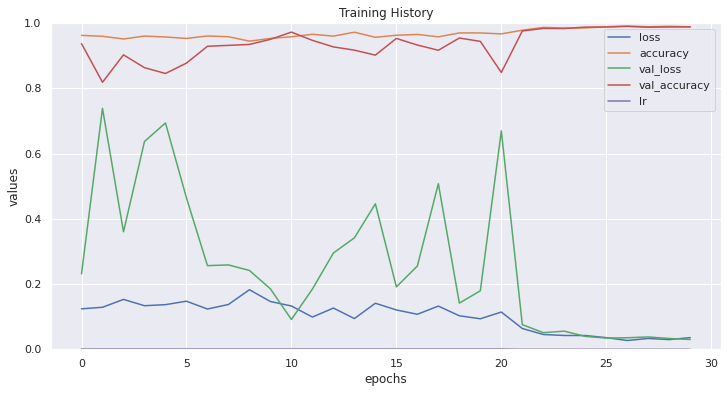

In [54]:
pd.DataFrame(history.history).plot(figsize=(12,6))
plt.title('Training History')
plt.xlabel('epochs')
plt.ylabel('values')
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [55]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 83 kB 2.0 MB/s 
     |████████████████████████████████| 185 kB 60.9 MB/s 
     |████████████████████████████████| 16.0 MB 53.6 MB/s 
     |████████████████████████████████| 40 kB 6.2 MB/s 
     |████████████████████████████████| 578.0 MB 16 kB/s 
     |████████████████████████████████| 145 kB 69.7 MB/s 
     |████████████████████████████████| 237 kB 75.0 MB/s 
     |████████████████████████████████| 51 kB 6.2 MB/s 
     |████████████████████████████████| 438 kB 71.8 MB/s 
     |████████████████████████████████| 5.9 MB 52.0 MB/s 
     |████████████████████████████████| 1.7 MB 48.7 MB/s 
     |████████████████████████████████| 85 kB 4.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  At

In [1]:
!tensorflowjs_converter --input_format keras /content/final_model.h5 /content/tensorflow-model/

2022-10-16 04:27:17.075428: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-16 04:27:17.399735: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-16 04:27:18.734843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-10-16 04:27:18.735780: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cann

In [2]:
!zip -r /content/tensorflow-model.zip /content/tensorflow-model

  adding: content/tensorflow-model/ (stored 0%)
  adding: content/tensorflow-model/group1-shard1of4.bin (deflated 7%)
  adding: content/tensorflow-model/group1-shard4of4.bin (deflated 7%)
  adding: content/tensorflow-model/group1-shard2of4.bin (deflated 7%)
  adding: content/tensorflow-model/group1-shard3of4.bin (deflated 7%)
  adding: content/tensorflow-model/model.json (deflated 94%)


In [ ]:
from google.colab import files
files.download('/content/sample_data/README.md')